In [21]:
from __future__ import division, print_function
import cPickle
import os
import glob
import os.path as op
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd
import os
import os.path as op
import glob
from nilearn.plotting import plot_stat_map
from scipy.stats import f_oneway, ttest_rel, pearsonr, t
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skbold.data2mvp import Fsl2mvp
%matplotlib inline
sns.set_style("ticks")

project_dir = '/media/lukas/data/SharedStates'
data_dir = op.join(project_dir, 'DATA', 'MVPA')
results_dir = op.join(project_dir, 'RESULTS', 'MVPA')
plot_dir = op.join(project_dir, 'ARTICLE', 'Plots')

In [22]:
def compute_score_confmat(confmat, metric='precision'):
    
    if metric == 'precision':
            return confmat / confmat.sum(axis=0)
    elif metric == 'recall':
        return confmat / confmat.sum(axis=1)
    elif metric == 'F1':
        precision = confmat / confmat.sum(axis=0)
        recall = confmat / confmat.sum(axis=1)
        return 2 * (recall * precision) / (recall + precision)

In [30]:
# Location of results from 100,000 iterations analysis
os_dir = op.join(results_dir, 'Validation/OtherWayAround/OTHER>>SELF')
permdir = op.join(os_dir, 'permutation_results')

In [24]:
os_files = glob.glob(op.join(os_dir, '*Zinnen*.pickle'))
os_cm_recall = np.zeros((len(os_files), 3, 3))
os_cm_prec = np.zeros((len(os_files), 3, 3))

for i, f in enumerate(os_files):
    tmp = cPickle.load(open(f)).conf_mat
    os_cm_recall[i, :, :] = compute_score_confmat(tmp, metric='recall')
    os_cm_prec[i, :, :] = compute_score_confmat(tmp, metric='precision')

os_cm_recall[np.isnan(os_cm_recall)] = 0
os_cm_prec[np.isnan(os_cm_prec)] = 0

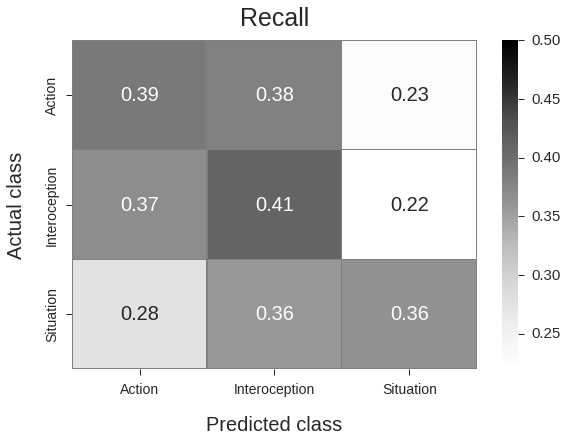

In [25]:
labels = ['Action', 'Interoception', 'Situation']
plt.figure(figsize=(8,6))
ax = sns.heatmap(os_cm_recall.mean(axis=0), cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.5, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Recall', fontsize=25, y=1.03)
plt.tight_layout(pad=0.3)
plt.savefig(op.join(plot_dir, 'other_to_self_recall.png'))

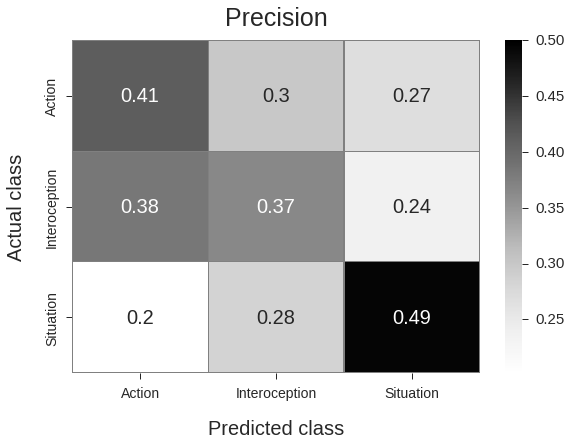

In [12]:
labels = ['Action', 'Interoception', 'Situation']
plt.figure(figsize=(8,6))
ax = sns.heatmap(os_cm_prec.mean(axis=0), cmap=plt.cm.Greys, annot=True,
                 linewidths=0.1, linecolor='grey', vmax=.5, cbar=True, annot_kws={'fontsize': 20})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
plt.xticks(np.arange(3)+0.5, labels, fontsize=14)
plt.yticks(np.arange(3)+0.5, labels[::-1], fontsize=14)
plt.xlabel('Predicted class', fontsize=20, labelpad=19)
plt.ylabel('Actual class', fontsize=20, labelpad=19)
plt.title('Precision', fontsize=25, y=1.03)
plt.tight_layout(pad=0.1)
plt.savefig(op.join(plot_dir, 'other_to_self_precision.png'))

In [104]:
permdirs = glob.glob(op.join(permdir, 'perm*'))[0:999]
perms = np.zeros((len(permdirs), 20, 3, 3))

for i, pdir in enumerate(permdirs):

    for ii, sub in enumerate(sorted(glob.glob(op.join(pdir, '*.npy')))):
        
        perms[i, ii, :, :] = np.load(sub)
perms = perms.sum(axis=1)

In [105]:
permprec = perms / perms.sum(axis=1)[:, :, np.newaxis]
permrecall = perms / perms.sum(axis=2)[:, :, np.newaxis]

all_perms = {'recall': permrecall,
              'precision': permprec}

all_obs = {'recall': os_cm_recall.mean(axis=0),
           'precision': os_cm_prec.mean(axis=0)}

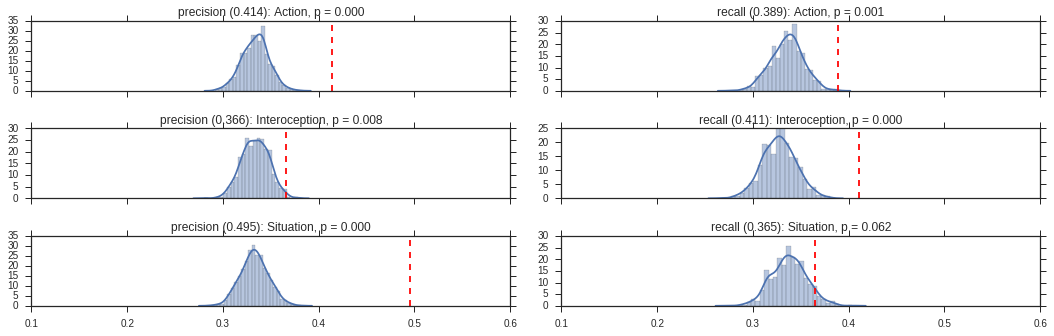

In [106]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(15, 5))

for i, cls in enumerate(['Action', 'Interoception', 'Situation']):
    
    for ii, metric in enumerate(['precision', 'recall']):
        perm_scores = all_perms[metric][:, i, i] 
        obs_score = all_obs[metric][i, i]
        
        p = (obs_score < perm_scores).sum() / perm_scores.shape[0]
        sns.distplot(perm_scores, ax=ax[i][ii])
        ax[i][ii].set_xlim((0.1, 0.6))
        ax[i][ii].axvline(x=obs_score, color='r', linestyle='--')
        ax[i][ii].set_title('%s (%.3f): %s, p = %.3f' % (metric, obs_score, cls, p))
plt.tight_layout(pad=2)